In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV

import os
from datetime import datetime
from pathlib import Path
import sys
import xlrd
import pycountry
from statistics import mean
import datetime as dt
import statsmodels.api as sm
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('review_is.csv')
df.head(3)

,Unnamed: 0,restaurant_name_x,url,reviewer,rating,date,location,number_of_friends,number_of_reviews,text,...,23,24,25,26,27,28,29,Negative_SentiStrength_Score,Positive_SentiStrength_Score,Average_SentiStrength_Score
0,0,Selden Standard,https://www.yelp.com/biz/selden-standard-detro...,Tiana O.,5,3/11/21,"Troy, MI",126,74,This is our favorite restaurant in Michigan an...,...,0.038694,0.002504,0.001064,0.000943,0.001865,0.065343,0.001309,-1,4,3
1,1,Selden Standard,https://www.yelp.com/biz/selden-standard-detro...,Christal P.,5,11/6/20,"Detroit, MI",196,466,I had such a nice dining experience at Selden ...,...,0.002343,0.000635,0.000270,0.000239,0.000473,0.053889,0.000332,-3,4,1
2,2,Selden Standard,https://www.yelp.com/biz/selden-standard-detro...,Vicki D.,5,2/8/21,"Chino Hills, CA",183,274,We came here for my daughter's birthday and it...,...,0.018516,0.001198,0.000509,0.000451,0.000892,0.087643,0.000626,-1,4,3


In [3]:
len(df)

9116

In [4]:
len(df['reviewer'].unique())

4657

In [5]:
df2 = df[['date', 'rating', 'number_of_reviews', 'number_of_friends',
          'Negative_SentiStrength_Score', 'Positive_SentiStrength_Score', 'Average_SentiStrength_Score', ]]

df2 = df2.rename(columns={'Negative_SentiStrength_Score': 'negative_sentiment', 'Positive_SentiStrength_Score': 'positive_sentiment',
                          'Average_SentiStrength_Score': 'average_sentiment', })

df2['date'] = pd.to_datetime(df2['date'], errors='coerce')
df2['date'] = df2['date'].map(dt.datetime.toordinal) - 733606

df2.head(3)

,date,rating,number_of_reviews,number_of_friends,negative_sentiment,positive_sentiment,average_sentiment
0,4254,5,74,126,-1,4,3
1,4129,5,466,196,-3,4,1
2,4223,5,274,183,-1,4,3


In [6]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df2.describe()

,date,rating,number_of_reviews,number_of_friends,negative_sentiment,positive_sentiment,average_sentiment
count,9116.00,9116.00,9116.00,9116.00,9116.00,9116.00,9116.00
mean,3678.07,4.07,174.32,150.90,-1.95,3.12,1.18
std,565.99,1.23,457.26,389.81,0.99,0.75,1.27
min,-568.00,1.00,1.00,0.00,-5.00,1.00,-4.00
25%,3459.00,4.00,12.00,3.00,-2.00,3.00,1.00
50%,3783.00,5.00,56.00,48.00,-2.00,3.00,1.00
75%,4090.00,5.00,171.00,156.00,-1.00,4.00,2.00
max,4342.00,5.00,15366.00,5000.00,-1.00,5.00,4.00


In [25]:
df2[df2['number_of_friends'] >= 1500]['average_sentiment'].values.mean()

1.2333333333333334

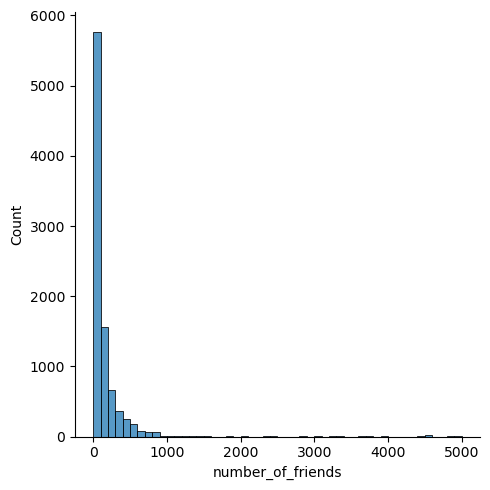

In [7]:
sns.displot(df2, x="number_of_friends", bins=50);

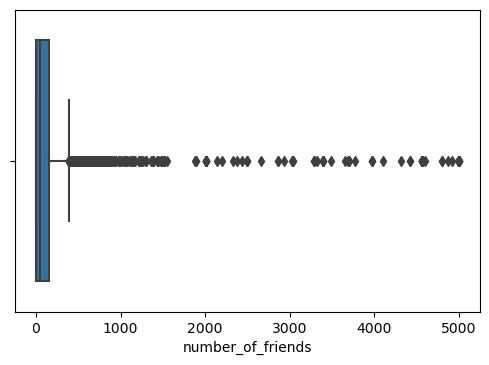

In [8]:
sns.boxplot(df2["number_of_friends"]);

In [9]:
len(df2[df2['number_of_friends'] <= 1000]) / len(df2)

0.9845326897762177

In [10]:
a = np.array(df2['number_of_friends'])
np.percentile(a, 99, axis=0)

1489.0

In [11]:
model_lin = sm.OLS.from_formula("number_of_friends ~ date + rating + negative_sentiment + positive_sentiment + average_sentiment + number_of_reviews", data=df2)
result_lin = model_lin.fit()
print(result_lin.summary())

                            OLS Regression Results                            
Dep. Variable:      number_of_friends   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     592.8
Date:                Sat, 03 Jul 2021   Prob (F-statistic):               0.00
Time:                        19:50:23   Log-Likelihood:                -66034.
No. Observations:                9116   AIC:                         1.321e+05
Df Residuals:                    9110   BIC:                         1.321e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             61.6091     31

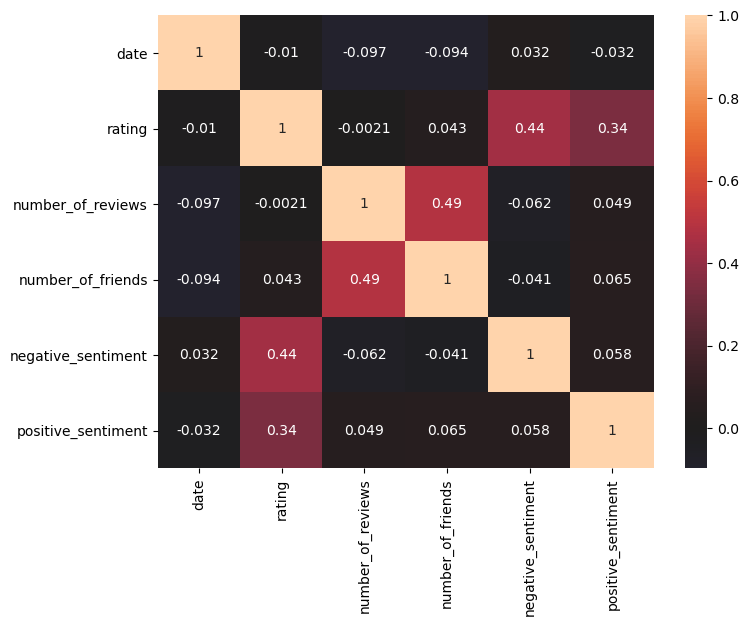

In [12]:
df3 = df2.drop(columns='average_sentiment')

corrmat = df3.corr()
plt.subplots(figsize=(8,6))
sns.heatmap(corrmat, center=0, annot=True);

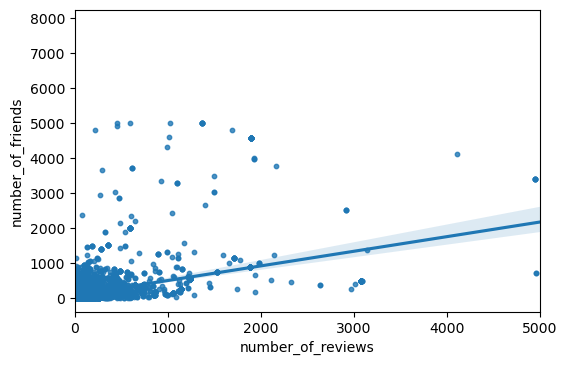

In [13]:
g = sns.regplot(x="number_of_reviews", y="number_of_friends", scatter_kws={'s':10}, data=df3)
g.set(xlim=(0, 5000));